In [5]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

# Running functions_bar_igw.ipynb

%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_borrador/IGW_BAR/functions_bar_igw.ipynb

In [6]:
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
import pandas as pd
from joblib import Parallel, delayed

def interpolate_to_target_grid(source_data, target_lat, target_lon, method='linear'):
    """
    Interpolates source_data to the target latitude and longitude grid using the specified method.
    """
    source_lat = source_data.lat.values
    source_lon = source_data.lon.values
    source_values = source_data.values

    # Interpolating using griddata with the specified method
    interpolated_data = griddata(
        np.array([source_lat.flatten(), source_lon.flatten()]).T,
        source_values.flatten(),
        (target_lat, target_lon),
        method=method
    )
    
    return interpolated_data

def process_data_for_time_step(time_step, ds, mask, dx):
    # Use 'ssh_hf' for interpolation
    ssh_data = ds.ssh_hf.sel(time_counter=time_step)
    
    # Interpolate ssh_bar (assuming ssh_bar and ssh_igw are derived from ssh_hf)
    ssh_bar_linear = interpolate_to_target_grid(ssh_data, target_lat2d, target_lon2d, method='linear')
    ssh_bar_nearest = interpolate_to_target_grid(ssh_data, target_lat2d, target_lon2d, method='nearest')
    ssh_bar_combined = np.where(np.isnan(ssh_bar_linear), ssh_bar_nearest, ssh_bar_linear)
    ssh_bar_interpolated = xr.DataArray(
        data=ssh_bar_combined,
        dims=ssh_dedac.ssh_dedac.dims,
        coords=ssh_dedac.ssh_dedac.coords
    ).drop_vars(['latitude', 'longitude'], errors='ignore')

    # Interpolate ssh_igw (same source for simplicity)
    ssh_igw_linear = interpolate_to_target_grid(ssh_data, target_lat2d, target_lon2d, method='linear')
    ssh_igw_nearest = interpolate_to_target_grid(ssh_data, target_lat2d, target_lon2d, method='nearest')
    ssh_igw_combined = np.where(np.isnan(ssh_igw_linear), ssh_igw_nearest, ssh_igw_linear)
    ssh_igw_interpolated = xr.DataArray(
        data=ssh_igw_combined,
        dims=ssh_dedac.ssh_dedac.dims,
        coords=ssh_dedac.ssh_dedac.coords
    ).drop_vars(['latitude', 'longitude'], errors='ignore')

    return ssh_bar_interpolated, ssh_igw_interpolated

# Example usage
path_to_mask = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc"
path_to_input = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_"
path_to_save_bar = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_bar/"
path_to_save_igw = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_igw/"
filename = "01.nc"
dx = 10

# Manually load the data
ssh_hf = xr.open_mfdataset(path_to_input + filename)
ds = ssh_hf.load()

# Load the mask
mask = xr.open_dataset(path_to_mask, drop_variables={"x", "y"}).tmaskutil[0, :, :].values

# Load target grid data
ssh_dedac = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60_dedac/ssh_dedac_masked_01.nc")
ssh_dedac = ssh_dedac.sel(time_counter=pd.to_datetime('2014-01-31T11:30:00')).load()

target_lat2d = ssh_dedac.nav_lat.values
target_lon2d = ssh_dedac.nav_lon.values

# Process the data for all time steps using parallel processing
results = Parallel(n_jobs=-1)(delayed(process_data_for_time_step)(time_step, ds, mask, dx) for time_step in ds.time_counter)

# Separate the results
ssh_bar_list, ssh_igw_list = zip(*results)

# Combine all the results into a single dataset
ssh_bar_combined = xr.concat(ssh_bar_list, dim='time_counter')
ssh_igw_combined = xr.concat(ssh_igw_list, dim='time_counter')




In [3]:
hf = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_01.nc")

In [4]:
hf

<xarray.Dataset> Size: 4GB
Dimensions:       (y: 853, x: 788, time_counter: 744)
Coordinates:
    lat           (y, x) float32 3MB dask.array<chunksize=(853, 788), meta=np.ndarray>
    lon           (y, x) float32 3MB dask.array<chunksize=(853, 788), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 6kB 2014-01-01T00:30:00 ... 2...
Dimensions without coordinates: y, x
Data variables:
    ssh_hf        (time_counter, y, x) float64 4GB dask.array<chunksize=(744, 853, 788), meta=np.ndarray>
Attributes:
    history:  Mon Jul  1 16:48:38 2024: ncrename -v __xarray_dataarray_variab...
    NCO:      netCDF Operators version 5.0.6 (Homepage = http://nco.sf.net, C...

In [7]:
ssh_bar_combined

<xarray.DataArray (time_counter: 744, y: 853, x: 788)> Size: 4GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,  0.0224165 ,  0.02245629, ..., -0.55793709,
         -0.55794748,         nan],
        [        nan,  0.02248385,  0.02252222, ..., -0.557962  ,
         -0.55797478,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,  0.6937831 ,  0.6937617 , ...,  0.05093039,
          0.05093164,         nan],
        [        nan,  0.69383004,  0.69380748, ...,  0.05095155,
          0.05095443,         nan],
        ...,
        [        nan, -0.02795566, -0.0279039 , ..., -0.80749715,
         -0.80750908,         nan],
        [        nan, -0.02789792, -0.02784727, ..., -0.80752589,
         -0.80754079,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
    nav_lat       (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    nav_lon       (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
  * time_counter  (time_counter) datetime64[ns] 6kB 2014-01-31T11:30:00 ... 2...
Dimensions without coordinates: y, x

In [8]:
# Create individual DataArrays with the correct variable names
ssh_bar_dataarray = xr.DataArray(
    data=ssh_bar_combined,
    dims=ssh_bar_combined.dims,
    coords=ssh_bar_combined.coords,
    name='ssh_bar'
)

ssh_igw_dataarray = xr.DataArray(
    data=ssh_igw_combined,
    dims=ssh_igw_combined.dims,
    coords=ssh_igw_combined.coords,
    name='ssh_igw'
)

In [12]:
test = ssh_bar_dataarray.sel(time_counter='2014-01-31T11:30:00')

In [13]:
test

<xarray.DataArray 'ssh_bar' (time_counter: 744, y: 853, x: 788)> Size: 4GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,  0.0224165 ,  0.02245629, ..., -0.55793709,
         -0.55794748,         nan],
        [        nan,  0.02248385,  0.02252222, ..., -0.557962  ,
         -0.55797478,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,  0.6937831 ,  0.6937617 , ...,  0.05093039,
          0.05093164,         nan],
        [        nan,  0.69383004,  0.69380748, ...,  0.05095155,
          0.05095443,         nan],
        ...,
        [        nan, -0.02795566, -0.0279039 , ..., -0.80749715,
         -0.80750908,         nan],
        [        nan, -0.02789792, -0.02784727, ..., -0.80752589,
         -0.80754079,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
    nav_lat       (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    nav_lon       (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
  * time_counter  (time_counter) datetime64[ns] 6kB 2014-01-31T11:30:00 ... 2...
Dimensions without coordinates: y, x

TypeError: Dimensions of C (744, 853, 788) should be one smaller than X(788) and Y(853) while using shading='flat' see help(pcolormesh)

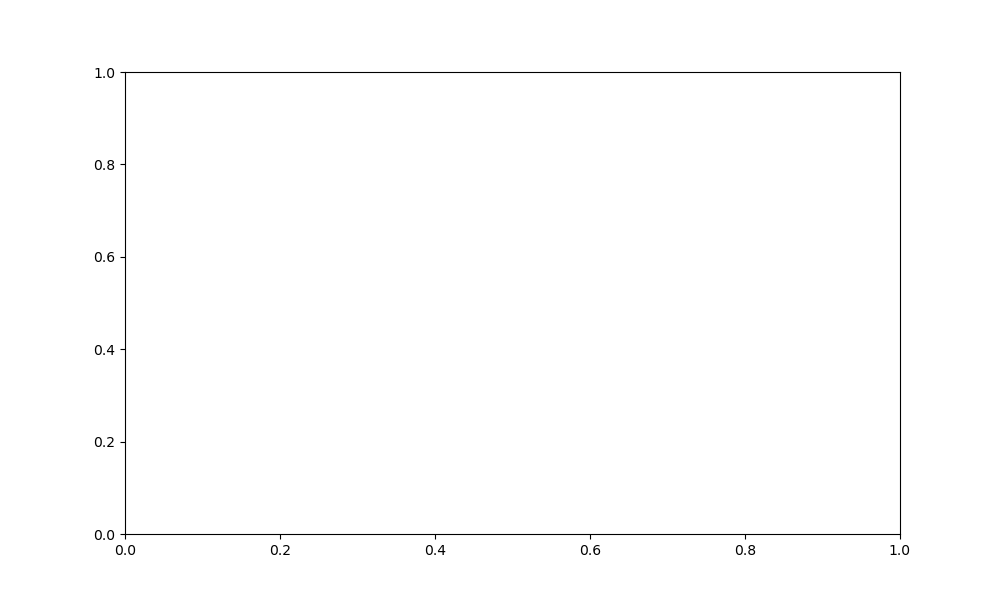

In [15]:
test = ssh_bar_dataarray.sel(time_counter='2014-01-31T11:30:00')

# Convert the 2D data array to a numpy array for plotting
data_2d = test.squeeze()

# Plot the selected data
plt.figure(figsize=(10, 6))
plt.pcolormesh(data_2d.nav_lon, data_2d.nav_lat, data_2d, cmap='viridis')
plt.colorbar(label='Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Data for 2014-01-31T11:30:00')
plt.show()